In [2]:
import sherpa
import pandas as pd
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup')
from config import C_COMMON, C_GRID, C_SINGLE, FILENAME
from util import load_data

from sklearn.linear_model import LinearRegression
import time

# enable autoreload
%load_ext autoreload
%autoreload 2

2022-08-19 19:44:00.520550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# conduct nested cross validation for xgboost.
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [3]:
columns = C_SINGLE
n_run = 100

df_train, _ = load_data(columns + C_COMMON, FILENAME)

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

class XGB():
    def __init__(self, params, columns):
        self.params = params
        self.columns = columns
        pass
    
    def cross_val_predict(self, df, skn, n_folds=5):
        assert 'inner_fold' in df.columns, 'define fold with column name "inner_fold"'
        df_station = df[df['skn'] == skn]
        
        list_ytrue = []
        list_ypred = []
        for k in range(n_folds):
            df_train = df_station[df_station['inner_fold'] != k]
            df_test = df_station[df_station['inner_fold'] == k]
            x_train, x_test = np.array(df_train[self.columns]), np.array(df_test[self.columns])
            y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])
            
            model = XGBRegressor(**self.params)
            model.fit(x_train, y_train)
            
            y_pred = model.predict(x_test)
            
            list_ytrue.extend(y_test)
            list_ypred.extend(y_pred)
        return {
            "mae": mean_absolute_error(list_ytrue, list_ypred),
            "rmse": mean_squared_error(list_ytrue, list_ypred, squared=False)
        }
    
    def evaluate(self, df_train, df_test):
        x_train, x_test = np.array(df_train[self.columns]), np.array(df_test[self.columns])
        y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])
        
        model = XGBRegressor(**params)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        return y_pred

In [ ]:
# def run_hyperparameter_tuning(study, model, df_train, columns):
#     dfs = []
#     for i, trial in enumerate(study):
#         params = {key: val for key, val in trial.parameters.items()}
#         for skn in df_train['skn'].unique():
#             model = model(**params, columns=columns)
#             ret = model.cross_predict(df_train, skn)
#             df = pd.DataFrame()
#             df['trial_id'] = i,
#             df['skn'] = [skn]
#             for key, val in ret.items():
#                 df[key] = [val]
#             for key, val in params.items():
#                 df[key] = [val]
#             dfs.append(df)
#     return pd.concat(dfs)
            

In [5]:
start = time.time()
# randomly choose params
parameters = [
    sherpa.Choice('n_estimators', list(range(100, 310, 10))),
    sherpa.Continuous('learning_rate', [0.001, 0.1]),
    sherpa.Discrete('max_depth', [1, 10]),
]
n_run = 1
study = sherpa.Study(
    parameters=parameters,
    algorithm=sherpa.algorithms.RandomSearch(max_num_trials=n_run),
    lower_is_better=True
)

dfs = []
for i, trial in enumerate(study):
    params = {key: val for key, val in trial.parameters.items()}
    for skn in tqdm(df_train['skn'].unique()):
        model = XGB(params=params, columns=columns)
        ret = model.cross_val_predict(df_train, skn)
        df = pd.DataFrame()
        df['trial_id'] = i,
        df['rmse'] = [ret['rmse']]
        df['mae'] = [ret['mae']]
        df['skn'] = [skn]
        for key, val in params.items():
            df[key] = [val]
        dfs.append(df)        
end = time.time()
print(end - start)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://10.100.11.207:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------
  0%|          | 0/24 [00:00<?, ?it/s]

 * Serving Flask app 'sherpa.app.app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


100%|██████████| 24/24 [01:19<00:00,  3.32s/it]

79.7818832397461


# Load data obtained from batch job for hyperparameter tuning

In [10]:
import matplotlib.pyplot as plt
df_result = pd.read_csv('xgb_report_500_single.csv', index_col=0)# .reset_index().rename(columns={'index': "rmse"})

In [29]:
df_groupby = df_result.groupby('trial_id').mean() # taking mean for hyperparameter won't affect the values
# df_groupby[df_groupby['rmse'] == df_groupby['rmse'].min()]. # get the row of the best performance

In [33]:
objective = 'rmse'
df_groupby[df_groupby[objective] == df_groupby[objective].min()][['n_estimators', 'learning_rate', 'max_depth']].iloc[0].to_dict()

{'n_estimators': 120.0, 'learning_rate': 0.0707547690637495, 'max_depth': 2.0}

In [22]:
best_param = {
    'n_estimators': 120,
    'learning_rate': 0.070755,
    'max_depth': 2
}

In [19]:
dict(n_estimators=100, learning_rate=0.039964, max_depth=4)

{'n_estimators': 100, 'learning_rate': 0.039964, 'max_depth': 4}

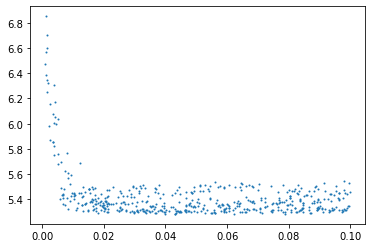

In [14]:
fig, ax = plt.subplots(1)
ax.scatter(df_result['learning_rate'], df_result['rmse'], s=1)

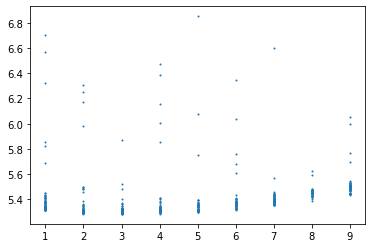

In [15]:
fig, ax = plt.subplots(1)
ax.scatter(df_result['max_depth'], df_result['rmse'], s=1)

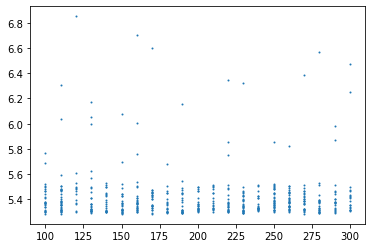

In [16]:
fig, ax = plt.subplots(1)
ax.scatter(df_result['n_estimators'], df_result['rmse'], s=1)

# Obtain the best juperparameter for each station

In [3]:
df_report = pd.read_csv('xgb_report_500_single.csv')

In [6]:
print('[')
for i, row in df_report.loc[df_report.groupby('skn')['rmse'].idxmin()].iterrows():
    temp = {
        'skn': row['skn'],
        'params': row[['n_estimators', 'learning_rate', 'max_depth']].to_dict()
    }
    print('\t', end='')
    print(temp, end=',\n')
print(']')

[
	{'skn': 54.0, 'params': {'n_estimators': 190.0, 'learning_rate': 0.0278494204777852, 'max_depth': 3.0}},
	{'skn': 79.0, 'params': {'n_estimators': 190.0, 'learning_rate': 0.0949351566190501, 'max_depth': 2.0}},
	{'skn': 87.0, 'params': {'n_estimators': 280.0, 'learning_rate': 0.0621165770493785, 'max_depth': 2.0}},
	{'skn': 250.0, 'params': {'n_estimators': 160.0, 'learning_rate': 0.0477286292178665, 'max_depth': 1.0}},
	{'skn': 267.0, 'params': {'n_estimators': 110.0, 'learning_rate': 0.0736598267207753, 'max_depth': 1.0}},
	{'skn': 296.1, 'params': {'n_estimators': 170.0, 'learning_rate': 0.0795342459742735, 'max_depth': 1.0}},
	{'skn': 311.0, 'params': {'n_estimators': 110.0, 'learning_rate': 0.0522478549248433, 'max_depth': 1.0}},
	{'skn': 338.0, 'params': {'n_estimators': 100.0, 'learning_rate': 0.028557265444767, 'max_depth': 4.0}},
	{'skn': 396.0, 'params': {'n_estimators': 260.0, 'learning_rate': 0.0678516814721514, 'max_depth': 1.0}},
	{'skn': 400.0, 'params': {'n_estimator